# 1-3 D CODE

In [1]:
import numpy as np
import matplotlib
import math
import time
import pickle


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import itertools


import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import tensorflow_probability as tfp


%matplotlib inline

## Run auxiliary functions and loading example library:

In [2]:
%run ./auxiliary_func.ipynb

## Choose input/output dimensions and look at the examples

In [3]:
## Allowed input/output values in this preliminary version are (ni=2 no=1) (ni=3 no=1) (ni=3 no=2) and (ni=1 no=1) 

ni=1 #number of input variables  
no=1 #number of output solutions 

#LOOK AT THE PDE DICTIONARIES MATCHING THE DIMENSION REQUIREMENTS
#################################################################################
### outputfunction is named u, v
### first derivatives are named dudt, dudx, dudy
### pure second derivatives are named dduddt, dduddx, dduddy
### mixed second derivative (as ddudtdx) need to be coded in the loss function, we will provide an automatic derivation in future updates.
############## NOTATION #####################
## eomdict: impose PDE constraints. The form needs to be '[ eq1 , eq2 ]' 
## ICdict: Boundary conditions on t belonging to [t0,tL].
##         The form needs to be [ '[ u - u(t0,x,y),dudt - dudt(t0,x,y)]' , '[u - u(tL,x,y),dudt - dudt(tL,x,y)]' ] 
##         If no condition needs to be provided on some boundary just replace (u - u(t,x,y0) ) with  [none].
## boardx: Boundary conditions on x belonging to [x0,xL].
##         The form needs to be [ '[u - u(t,x0,y),dudx - dudx(t,x0,y)]' , '[u - u(t,xL,y),dudx - dudx(t,xL,y)]' ]   
##         If no condition needs to be provided on some boundary just replace (u - u(t,x,y0) ) with  [none].
## boardy: Boundary conditions in y belonging to [y0,yL].
##         The form needs to be [ '[u - u(t,x,y0),dudy - dudy(t,x,y0)]' , '[u - u(t,x,yL),dudy - dudy(t,x,yL)]' ] 
##         If no condition needs to be provided on some boundary just write  [none].
## wdict:  weights to be used in loss function
##         The form needs to be [w_bulk,w_IC,w_board]

eqname_dict=eqname_gen(ni,no)
analytic=eqname_analytic(ni,no)
sol=sol_analytic(ni,no)

if ni==1:
    eomdict,ICdict=dictgen(ni,no)
elif ni==2:
    eomdict,ICdict,boardx,wdict=dictgen(ni,no)
elif ni==3:
    eomdict,ICdict,boardx,boardy,wdict=dictgen(ni,no)

eomdict

{'oscillon': '[dduddt-0.5**2*u+2.*u**3.]',
 'mat': '[dduddt+(1.-0.4*tf.cos(2.*t))*u]',
 'exp': '[dudt+0.5*u]',
 'wave': '[dduddt+25.*u]',
 'dho': '[dduddt+0.5*dudt+25.*u]',
 'linear': '[dudt-1.]',
 'delay': '[dudt-0.5*u+1.*du]',
 'gaussian': '[dudt+0.2*t*u]',
 'stiff': '[dudt+21.*u-tf.exp(-t)]',
 'twofreq': '[dduddt+u+2.*tf.cos(5.*t)+6.*tf.sin(10.*t)]'}

In [4]:
#####################################################
#### Choose the equation of motion to be studied
#####################################################
### 1 PDE in 3D studied: ['waveb','wave','wavet', 'poisson1', 'poisson2', 'poisson3','heat1','heat2']
### 2 PDEs in 3D studied: ['GT','LO','NS']
### 1 PDE in 2D studied: [{'wave','waveN','twave','heat','heat2f','heat0','poisson','poisson1','AdvectionDiffusion','Burgers','poisson_par','par']
### 1 ODE (in 1D) studied: [{'oscillon', 'mat', 'exp', 'wave', 'dho', 'linear', 'delay', 'gaussian', 'stiff', 'twofreq'}]
#####
##Create the list of coordinate boundaries, i.e. boundaries=[t_0,t_max,x_0,x_max,y_0,y_max]
#### Boudaries used in the paper
#bd=[0.,1.,0.,1.,0.,1.]               # 1 PDE in 3D
#bd=[0.,1.,0.,2.*np.pi,0.,2.*np.pi]   #'GT'
#bd=[0.1,1.,-2.,2.,-2.,2.]            #'LO'
#bd=[0.,10.,0.,1.,0.,1.]              #'NS'
#bd=[0.,1.,0.,1.]                     # 1 PDE in 2D
#bd=[0.,20.]                          # 1 ODE


eom='twofreq'

domain='rect'                   #'rect' or 'disk', just for PDEs in 2D

bd=[0.,20.] 



## define number of points to be sampled in the bulk, the IC and on each boundary surface, and the mini-batch size
## for the 1D case (n_bulk, n_IC) will evaluate to (batch_sz-2,2) for the training part of adam
n_bulk=2000
n_IC=100
n_board=10
batch_sz=256


#Define dataset from random sampling the domain
if eom=='NS':
    n_bo=int((4*n_board)/((n_bulk+n_IC)/256))
    X_data, t, x, y=random_sampling_bulk_IC(bd,n_bulk,n_IC)
    I0,Itl,_,_,_,_,Ib=tf.split(counters(ni)(bd,t,x,y),7,1)
    I=tf.concat([I0,Itl,Ib],1)
    fake_output=tf.concat([X_data,I],axis=1)
    step=0.25;
    inputs=[t, x, y]
elif ni==3:
    X_data, t, x, y=  (random_sampling(ni))(bd,n_bulk,n_IC,n_board)
    #Define IC, boundary and bulk counters (I_t0,I_tL,I_x0,I_xL,I_y0,I_yL,I_bulk)
    I=counters(ni)(bd,t,x,y)
    fake_output=tf.concat([X_data,I],axis=1)
    step=1.
    inputs=[t, x, y]
elif ni==2 and domain=='rect':
    X_data, t, x=  (random_sampling(ni,domain))(bd,n_bulk,n_IC,n_board)
    #Define IC, boundary and bulk counters (I_t0,I_tL,I_x0,I_xL,I_y0,I_yL,I_bulk)
    I=counters(ni,'rect')(bd,t,x)
    fake_output=tf.concat([X_data,I],axis=1)
    step=1.
    inputs=[t, x]
elif ni==2 and domain=='disk':
    X_data, t, x=  (random_sampling(ni,domain))(bd,n_bulk,n_board)
    #Define IC, boundary and bulk counters (I_t0,I_tL,I_x0,I_xL,I_y0,I_yL,I_bulk)
    I=counters(ni,'disk')(bd,t,x)
    #I_t0,I_tL,I_x0,I_xL,I_y0,I_yL,I_bulk=tf.split(I,7,1) ##REMOVE
    fake_output=tf.concat([X_data,I],axis=1)
    step=1.
    inputs=[t, x]
elif ni==1:
    X_data = (random_sampling(ni))(bd,n_bulk,n_IC)
    #Define ic, bc and bulk counters (I_t0,I_tL,I_bulk)
    I=counters(ni)(bd,X_data)
    fake_output=tf.concat([X_data,I],axis=1)
    step=2.
    inputs=[X_data]
# elif ni==1:
#     #Mini-batch sized prototype dataset for adam
#     X_data = (random_sampling(ni))(bd,batch_sz-2,1)
#     #Define ic, bc and bulk counters (I_t0,I_tL,I_bulk)
#     I=counters(ni)(bd,X_data)
#     [I_t0,I_tL,I_bulk]= tf.split(I,3,axis=1)
#     fake_output=tf.concat([X_data,I],axis=1)
#     step=2.
#     inputs=[X_data]
    
#     #Larger dataset for BFGS
#     X_data_bfgs = (random_sampling(ni))(bd,n_bulk,n_IC)
#     I=counters(ni)(bd,X_data_bfgs)
#     fake_output_bfgs=tf.concat([X_data_bfgs,I],axis=1)
    


##Initialise the network
n_l=35 #number of neurons per branch

#create base frequencies to initialize the network
pi=tf.constant(np.pi,dtype=tf.float32)
none=tf.constant(0.,dtype=tf.float32)
if ni==3:
    freq_t,freq_x,freq_y=base_freq(ni,bd)
elif ni==2:
    freq_t,freq_x=base_freq(ni,bd)
elif ni==1:
    freq_t=base_freq(ni,bd)

model=dNNsolve(ni,no,n_l,bd,step)

model.save_weights(f"model_seq_{ni}D_{n_l}nodes.h5")


## Training and plots

Epoch 0:	   log10 loss:    1.10 
Epoch 10:	   log10 loss:    0.07 
Epoch 20:	   log10 loss:    0.03 
Epoch 30:	   log10 loss:    0.04 
Epoch 40:	   log10 loss:    0.02 
Epoch 50:	   log10 loss:    0.11 
Epoch 60:	   log10 loss:   -0.05 
Epoch 70:	   log10 loss:   -0.07 
Epoch 80:	   log10 loss:   -0.11 
Epoch 90:	   log10 loss:   -0.07 
Epoch 100:	   log10 loss:   -0.11 
Epoch 110:	   log10 loss:   -0.37 
Epoch 120:	   log10 loss:   -0.44 
Epoch 130:	   log10 loss:   -0.52 
Epoch 140:	   log10 loss:   -0.45 
Epoch 150:	   log10 loss:   -0.43 
Epoch 160:	   log10 loss:   -0.45 
Epoch 170:	   log10 loss:   -0.45 
Epoch 180:	   log10 loss:   -0.41 
Epoch 190:	   log10 loss:   -0.44 
Iter: 50 loss: 264.493774
Iter: 100 loss: 176.377563
Iter: 150 loss: 2.56746244
Iter: 200 loss: 0.0219508149
Iter: 250 loss: 0.0769574642
Iter: 300 loss: 0.00280406699
Iter: 350 loss: 0.00114208611
Iter: 400 loss: 0.000501076225


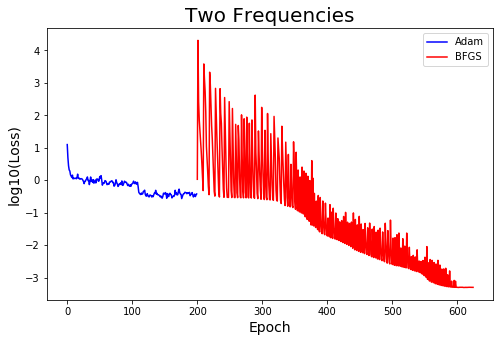

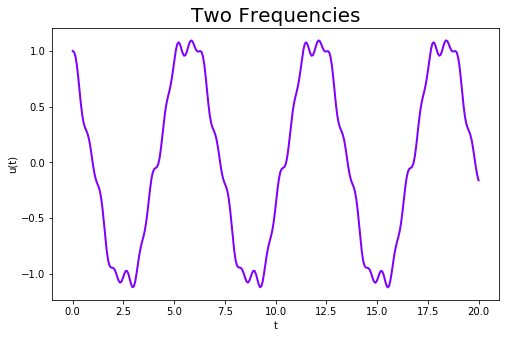


 EOM: twofreq

 Neurons per branch:  35

 Epochs:  625

 Total Time: 109.8221

 Final log10(Loss Adam): -0.4238

 Final log10(Loss): -3.3021

 Log10 of Mean squared error:  -3.1655

 log10(Loss bulk): -3.3024 log10(Loss IC): -6.5427 log10(Loss board): -20.0000

 #######################################################


In [5]:
epochs_adam=200  
    
start=time.time() 

#initialization of models
model.load_weights(f"model_seq_{ni}D_{n_l}nodes.h5") #Restore weights to original values at each iteration
if ni==3 and no==1:
    loss_fun=to_loss_3to1(eom)
elif ni==3 and no==2:
    loss_fun=to_loss_3to2(eom)
elif ni==2:
    loss_fun=to_loss_2to1(eom,domain)
elif ni==1:
    loss_fun=to_loss_1to1(eom) 
# elif ni==1:
#     loss_fun=to_loss_1to1_minibatch(eom) 
#     loss_fun_bfgs=to_loss_1to1(eom) 

    
# an educated guess for the oscillon central amplitude
if ni==1 and eom=='oscillon':
    u0guess=tf.constant(0.6)
    
#Initialise BFGS method and compile the model
# if ni==1:
#     func = function_factory(model, loss_fun_bfgs, fake_output_bfgs)
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
#                            loss=loss_fun,run_eagerly=False)
# else: 
#     func = function_factory(model, loss_fun, fake_output)
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
#                            loss=loss_fun,run_eagerly=False)   
func = function_factory(model, loss_fun, fake_output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                        loss=loss_fun,run_eagerly=False)

#Training with Adam
hist = model.fit(x=inputs, y=fake_output, batch_size = batch_sz, epochs=epochs_adam, verbose=0, callbacks = 
                    [Print_Loss_Every_so_many_Epochs(),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', mode='min', factor=1./2., patience=30, min_lr=1e-4)])

#Training with BFGS
init_params = tf.dynamic_stitch(func.idx, model.trainable_variables)
results = tfp.optimizer.bfgs_minimize(value_and_gradients_function=func, initial_position=init_params,tolerance=1e-20, max_iterations=5000)    
func.assign_new_model_parameters(results.position)



#Store loss data
loss_adam=np.array(hist.history['loss'],dtype=np.float32) 
history_lbfgs=np.array(func.history)
hist_lbfgs=np.array(history_lbfgs[:,0])
loss=np.concatenate((loss_adam,hist_lbfgs))
end=time.time()


######## LOSS PLOT
xadam=np.arange(0,(loss_adam.size+hist_lbfgs.size)+1)[0:epochs_adam]
xbfgs=np.arange(0,(loss_adam.size+hist_lbfgs.size)+1)[epochs_adam:-1]
changeopt=np.array(loss_adam,dtype=np.float32).size
fig, axes = plt.subplots(1, sharex=True, figsize=(8, 5))
axes.set_ylabel("log10(Loss)", fontsize=14)
axes.set_xlabel("Epoch", fontsize=14)
axes.plot(xadam, np.log10(loss_adam), label = f"Adam", color = 'blue')
axes.plot(xbfgs, np.log10(hist_lbfgs) , label = f"BFGS", color = 'red')
plt.title(eqname_dict[eom], fontsize=20)
plt.legend()
plt.show()


######## SOLUTION PLOT 
if ni==3 and no==1:
    nplot=30
    t_frames=30
    fps = 10 # frame per sec
    points_u, mse, x_p, y_p = points_plt_mse(ni,no,bd,model,sol)

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_xlim3d([float(bd[2]), float(bd[3])])
    ax.set_ylabel('Y')
    ax.set_ylim3d([float(bd[4]), float(bd[5])])
    ax.set_zlabel('u (x,y)')
    ax.set_zlim3d([tf.reduce_min(points_u).numpy(), tf.reduce_max(points_u).numpy()])
    ax.view_init(30, 60)
    ttl=plt.title(eqname_dict[eom], fontsize=15)
    ttl.set_position([.5, 0.95])
    plot = [ax.plot_surface(x_p,y_p,  points_u[:,:,0], color='0.75', rstride=1, cstride=1, cmap="magma")]
    ani = animation.FuncAnimation(fig, update_plot_3to1, t_frames, fargs=(points_u, plot), interval=1000/fps)
    plt.rcParams['animation.html'] = 'html5'
    ##uncomment these cells to save the animation plot in mp4 or gif format
    #fn = f'gif_{eom}_2opt'
    #ani.save(fn+'.mp4',writer='ffmpeg',fps=fps)
    #ani.save(fn+'.gif',writer='imagemagick',fps=fps)

elif ni==3 and no==2:
    nplot=30    #points per side in the spatial grid 
    t_frames=40 #number of time frames
    fps = 5     # frame per sec
    points_u, points_v, mse, x_p, y_p = points_plt_mse(ni,no,bd,model,sol)
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ttl=plt.title(eqname_dict[eom], fontsize=15)
    M = np.hypot(points_u[:,:,0],points_v[:,:,0])
    plot = [ax.quiver(x_p, y_p, points_u[:,:,0],points_v[:,:,0], [M], units='width',scale=1 / 0.15)]
    ani = animation.FuncAnimation(fig, update_plot_3to2, t_frames, fargs=(points_u,points_v, plot), interval=1000/fps)
    plt.rcParams['animation.html'] = 'html5'
    ##uncomment these cells to save the animation plot in mp4 or gif format
    #fn = f'gif_{eom}_2opt'
    #ani.save(fn+'.mp4',writer='ffmpeg',fps=fps)
    #ani.save(fn+'.gif',writer='imagemagick',fps=fps)
    
elif ni==2 and domain=='rect':
    n_plt=51
    pred, mse, tplt, xplt=points_plt_mse(ni,no,bd,model,sol,domain='rect')
    tplt= tf.reshape(tplt,(n_plt,n_plt))
    xplt= tf.reshape(xplt,(n_plt,n_plt))
    pred= tf.reshape(pred,(n_plt,n_plt)) 
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, -30)
    ttl=plt.title(eqname_dict[eom], fontsize=15)
    ttl.set_position([.5, 0.95])
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.plot_surface(tplt,xplt,pred,color='0.75', rstride=1, cstride=1, cmap="magma")
    ##uncomment this cell to save the final plot
    #plt.savefig(f'plot_{mod}_{eom}_2D_2opt.png', dpi=300, bbox_inches='tight', cmap="magma")
elif ni==2 and domain=='disk':
    n_plt=51
    pred, mse, tplt, xplt=points_plt_mse(ni,no,bd,model,sol,domain='disk')
    tplt= tf.reshape(tplt,(n_plt,n_plt))
    xplt= tf.reshape(xplt,(n_plt,n_plt))
    pred= tf.reshape(pred,(n_plt,n_plt))
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, -30)
    ttl=plt.title(eqname_dict[eom], fontsize=15)
    ttl.set_position([.5, 0.95])
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.plot_surface(tplt,xplt,pred,color='0.75', rstride=1, cstride=1, cmap="magma")
    ##uncomment this cell to save the final plot
    #plt.savefig(f'plot_{mod}_{eom}_2D_2opt.png', dpi=300, bbox_inches='tight', cmap="magma")
elif ni==1:
    n_plt=300
    pred, mse, tplt=points_plt_mse(ni,no,bd,model,sol) 
    colors = plt.cm.rainbow(np.linspace(0, 1, no))
    fig,ax = plt.subplots(figsize=(8, 5))
    ax.set_xlabel('t')
    ax.set_ylabel('u(t)')
    ax.set_title(eqname_dict[eom], fontsize=20)
    for i in range(no):
        ax.plot(tplt, pred[:,i], label = f"Field {i+1}", linewidth=2.0, color = colors[i])
    #ax.legend()
    plt.show()
    ##uncomment this cell to save the final plot
    #plt.savefig(f'plot_{mod}_{eom}_1D_1opt.png', dpi=300, bbox_inches='tight')


eps=1e-20 ##small parameter to avoid inf values
print('\n EOM: ' + eom)
print('\n Neurons per branch:  %s' % (n_l))
print('\n Epochs:  %s' % (loss.size))
print('\n Total Time: %.4f' % (end-start))
print('\n Final log10(Loss Adam): %.4f' % (np.log10(loss_adam[-1])+eps))
print('\n Final log10(Loss): %.4f' % (np.log10(loss[-1])+eps))
print('\n Log10 of Mean squared error:  %.4f' % (np.log10(mse+1e-20)+eps))
print('\n log10(Loss bulk): %.4f log10(Loss IC): %.4f log10(Loss board): %.4f' % (np.log10(eps+np.array(history_lbfgs[:,1])[-1]),np.log10(eps+np.array(history_lbfgs[:,2])[-1]),np.log10(eps+np.array(history_lbfgs[:,3])[-1])))
print('\n #######################################################')



## Show animation (for 3D plots)

In [ ]:
ani